In [1]:
import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)
 
# 切换到上一层目录
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)
print("切换后的目录：", parent_dir)

当前工作目录： /Users/lig/Documents/GitHub/NEMESIS/unit_test
切换后的目录： /Users/lig/Documents/GitHub/NEMESIS


In [2]:
from nemesis.utils import *
from nemesis.products.rates import *

####################################################################
#  ValLib ALPHA Version 0.1.0 - This build: 24 Jan 2025 at 10:42 #
####################################################################



# Build SOFR curve

In [3]:
value_dt = Date(27,11,2024)
spot_days = 2
cal_type = CalendarTypes.UNITED_STATES
cal = Calendar(cal_type)
settle_dt = cal.add_business_days(value_dt, spot_days)

notional = 1000000

fixed_type = SwapTypes.PAY
fixed_freq = FrequencyTypes.ANNUAL
fixed_dc_type = DayCountTypes.ACT_360

spread = 0
float_freq = FrequencyTypes.ANNUAL
float_dc_type = DayCountTypes.ACT_360

bd_type = BusDayAdjustTypes.MODIFIED_FOLLOWING
dg_type = DateGenRuleTypes.BACKWARD

In [4]:
swap_mkt_data = pd.read_excel("./unit_test/data/sofr_curve_data_20241127.xlsx", sheet_name='swap')

In [5]:
maturity_dates = [settle_dt.add_business_tenor(tenor, cal_type=CalendarTypes.UNITED_STATES) for tenor in swap_mkt_data["Tenor"]]

swaps = [
    OIS(
        effective_dt = settle_dt,
        term_dt_or_tenor = tenor,
        fixed_leg_type = fixed_type,
        fixed_cpn = rate,
        fixed_freq_type = FrequencyTypes.ANNUAL,
        fixed_dc_type = fixed_dc_type,
        notional = notional,
        payment_lag = 0,
        float_spread = spread,
        float_freq_type = FrequencyTypes.ANNUAL,
        float_dc_type = float_dc_type,
        cal_type = cal_type,
        bd_type = bd_type,
        dg_type = dg_type
    )
    for mat_date, tenor, rate in zip(maturity_dates, swap_mkt_data["Tenor"], swap_mkt_data["Rate"]) 
    if mat_date <= settle_dt.add_business_tenor("3W", cal_type)
] + [
    OIS(
        effective_dt = settle_dt,
        term_dt_or_tenor = tenor,
        fixed_leg_type = fixed_type,
        fixed_cpn = rate,
        fixed_freq_type = fixed_freq,
        fixed_dc_type = fixed_dc_type,
        notional = notional,
        payment_lag = 0,
        float_spread = spread,
        float_freq_type = float_freq,
        float_dc_type = float_dc_type,
        cal_type = cal_type,
        bd_type = bd_type,
        dg_type = dg_type
    )
    for mat_date, tenor, rate in zip(maturity_dates, swap_mkt_data["Tenor"], swap_mkt_data["Rate"]) 
    if mat_date > settle_dt.add_business_tenor("3W", cal_type) and mat_date <= settle_dt.add_business_tenor("1Y", cal_type)
] + [
    OIS(
        effective_dt = settle_dt,
        term_dt_or_tenor = tenor,
        fixed_leg_type = fixed_type,
        fixed_cpn = rate,
        fixed_freq_type = fixed_freq,
        fixed_dc_type = fixed_dc_type,
        notional = notional,
        payment_lag = 2,
        float_spread = spread,
        float_freq_type = float_freq,
        float_dc_type = float_dc_type,
        cal_type = cal_type,
        bd_type = bd_type,
        dg_type = dg_type
    )
    for mat_date, tenor, rate in zip(maturity_dates, swap_mkt_data["Tenor"], swap_mkt_data["Rate"]) 
    if mat_date > settle_dt.add_business_tenor("1Y", cal_type)
]

In [6]:
swaps = [
    OIS(
        effective_dt = settle_dt,
        term_dt_or_tenor = tenor,
        fixed_leg_type = fixed_type,
        fixed_cpn = rate,
        fixed_freq_type = FrequencyTypes.ANNUAL,
        fixed_dc_type = DayCountTypes.ACT_360,
        notional = notional,
        payment_lag = 0,
        float_spread = spread,
        float_freq_type = FrequencyTypes.ANNUAL,
        float_dc_type = DayCountTypes.ACT_360,
        cal_type = CalendarTypes.UNITED_STATES,
        bd_type = BusDayAdjustTypes.FOLLOWING,
        dg_type = DateGenRuleTypes.BACKWARD
    )
    for mat_date, tenor, rate in zip(maturity_dates, swap_mkt_data["Tenor"], swap_mkt_data["Rate"]) 
    if mat_date <= settle_dt.add_business_tenor("3W", cal_type)
]

In [7]:
payment_dates = maturity_dates.copy()
idx = np.where(np.array(payment_dates) == settle_dt.add_business_tenor("18M", cal_type=CalendarTypes.UNITED_STATES))[0][0]
payment_dates[idx:] = [cal.add_business_days(pivot, 2) for pivot in payment_dates[idx:]]

In [8]:
sofr_curve = OISCurve(value_dt, [], [], swaps, interp_type=InterpTypes.LINEAR_ZERO_RATES)

In [9]:
sofr_curve.df(Date(9,12,2024), DayCountTypes.ACT_ACT_ISDA)

0.9984711445673078

In [10]:
sofr_curve._dfs[1]

0.9984669591346085

In [11]:
sofr_curve.df(Date(9,12,2024), day_count=DayCountTypes.ACT_365L)

0.9984669591346085

In [12]:
sofr_curve._df_to_zero(sofr_curve.df(Date(23,12,2024), day_count=DayCountTypes.ZERO), Date(23,12,2024), freq_type=FrequencyTypes.CONTINUOUS, dc_type=DayCountTypes.ACT_365L)

array([0.04631084])

In [13]:
sofr_curve.print_table(payment_dates)

,Date,ZR,DF
0,09-DEC-2024,4.65383,0.998471
1,16-DEC-2024,4.65383,0.997580
2,23-DEC-2024,4.63108,0.996707
3,02-JAN-2025,4.63120,0.995443
4,03-FEB-2025,4.63701,0.991398
5,03-MAR-2025,4.63891,0.987873
6,02-APR-2025,4.64001,0.984110
7,02-MAY-2025,4.64069,0.980361
8,02-JUN-2025,4.64116,0.976502
9,02-JUL-2025,4.64149,0.972783


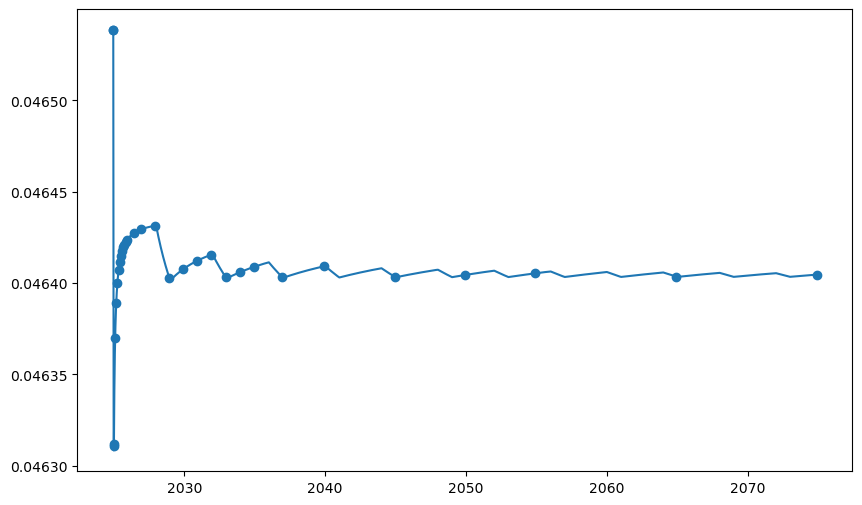

In [14]:
sofr_curve.print_figure(payment_dates)

# IRS Valuation

In [15]:
swap = OIS(
    effective_dt=Date(19, 7, 2024),
    term_dt_or_tenor=Date(18, 7, 2027),
    fixed_leg_type=fixed_type,
    fixed_cpn=0.05558,
    fixed_freq_type=fixed_freq,
    fixed_dc_type=fixed_dc_type,
    notional=32061781.09,
    payment_lag=0,
    float_spread=0,
    float_freq_type=FrequencyTypes.ANNUAL,
    float_dc_type=DayCountTypes.ACT_360,
    cal_type=CalendarTypes.UNITED_STATES,
    bd_type=BusDayAdjustTypes.MODIFIED_FOLLOWING,
    dg_type=DateGenRuleTypes.BACKWARD
)

In [18]:
swap

OBJECT TYPE: OIS
OBJECT TYPE: SwapFixedLeg
START DATE: 19-JUL-2024
TERMINATION DATE: 18-JUL-2027
MATURITY DATE: 19-JUL-2027
NOTIONAL: 32061781.09
PRINCIPAL: 0.0
LEG TYPE: SwapTypes.PAY
COUPON: 0.05558
FREQUENCY: FrequencyTypes.ANNUAL
DAY COUNT: DayCountTypes.ACT_360
CALENDAR: CalendarTypes.UNITED_STATES
BUS DAY ADJUST: BusDayAdjustTypes.MODIFIED_FOLLOWING
DATE GEN TYPE: DateGenRuleTypes.BACKWARD

OBJECT TYPE: SwapFloatLeg
START DATE: 19-JUL-2024
TERMINATION DATE: 18-JUL-2027
MATURITY DATE: 19-JUL-2027
NOTIONAL: 32061781.09
SWAP TYPE: SwapTypes.RECEIVE
SPREAD (BPS): 0
FREQUENCY: FrequencyTypes.ANNUAL
DAY COUNT: DayCountTypes.ACT_360
CALENDAR: CalendarTypes.UNITED_STATES
BUS DAY ADJUST: BusDayAdjustTypes.MODIFIED_FOLLOWING
DATE GEN TYPE: DateGenRuleTypes.BACKWARD

In [16]:
fixing = pd.read_excel("./unit_test/data/sofr_curve_data_20241127.xlsx", sheet_name='fixing')

In [17]:
swap.value(value_dt=value_dt, ois_curve=sofr_curve, first_fixing_rate=0.04674658104292555)

-790901.6109842779